# Mapas Covid

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import matplotlib.style as mst

#import seaborn as sns
import os
import geopandas as gpd
import geoplot
import mapclassify
from tensorflow.keras.utils import get_file

mst.use('ggplot')

## Carregando dados
Utilizando planilha do [Portal sobre Covid19 do Ministério da Saúde]('https://covid.saude.gov.br/')

In [156]:
df = pd.read_excel('./data/HIST_PAINEL_COVIDBR_21jun2020.xlsx')

## Tratamento inicial dos dados

In [157]:
df['populacaoTCU2019'] = df['populacaoTCU2019'].fillna('0')
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.split(pat='(', expand=True )
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.replace('.','').astype(int)

In [158]:
cat_dia_semana = pd.CategoricalDtype(categories=['dom', 'seg', 'ter', 'qua', 'qui', 'sex', 'sab'], ordered=True)
df['dia_semana'] = df['data'].dt.dayofweek
df['dia_semana_nm'] = df['dia_semana'].replace({0:'seg', 1: 'ter', 2:'qua', 3:'qui', 4:'sex', 5:'sab', 6:'dom'}).astype(cat_dia_semana)

## Entre com as silgas dos estados e o nome das cidades para comparar

In [159]:
uf_list= [ 'MS', 'AM']
Muni_list = ['Dourados', 'Manaus']


### Função de tratamento dos dados
* recebe o banco de dados, a sigla do estado e o nome da cidade
* retorna:
    1. DataFrame do estado
    1. DataFrame do estado agregado por semana epidemiológica
    1. DataFrame da cidade
    1. DataFrame da cidade agregado por semana epidemiológica


In [166]:
def preproc_comp_cidades(df1,estados, cidades):
    df1.sort_values('data', inplace = True)
    listDFs = []
    for i in range(len(estados)):
        # filtrando por estado
        fltr = df1['estado'].str.lower() == estados[i].lower()
        df_UF = df1.loc[fltr, :]
        # filtrando pro cidade
        fltr = df_UF['municipio'].str.lower() == cidades[i].lower()
        df_muni = df_UF.loc[fltr, :]

        ###
        #estado
        df_UF.dropna(subset=['municipio'])
        popu_estado = df_UF.groupby('municipio').agg({'populacaoTCU2019': 'max'}).reset_index()
        popu_estado = popu_estado['populacaoTCU2019'].sum()
        df_UF = df_UF.groupby('data')
        df_UF = df_UF.agg({'casosNovos': sum, 'obitosNovos': sum, 'casosAcumulado': sum, 'obitosAcumulado': sum,'populacaoTCU2019': 'max'}).reset_index()
        df_UF['CN_por_cemMil_Hab'] = df_UF['casosNovos'] * 10**5 / popu_estado
        df_UF['ON_por_cemMil_Hab'] = df_UF['obitosNovos'] * 10**5 / popu_estado
        df_UF['CA_por_cemMil_Hab'] = df_UF['casosAcumulado'] * 10**5 / popu_estado
        df_UF['OA_por_cemMil_Hab'] = df_UF['obitosAcumulado'] * 10**5 / popu_estado

        ## dias a partir da primeira notificação
        dia_0 = df_UF['data'].min()
        df_UF['dia_num'] = (df_UF['data'] - dia_0).apply(lambda x: x.days)
        
        ###
        #cidades
        df_muni['CN_por_cemMil_Hab'] = df_muni['casosNovos'] * 10**5 / df_muni['populacaoTCU2019']
        df_muni['ON_por_cemMil_Hab'] = df_muni['obitosNovos'] * 10**5 / df_muni['populacaoTCU2019']
        df_muni['CA_por_cemMil_Hab'] = df_muni['casosAcumulado'] * 10**5 / df_muni['populacaoTCU2019']
        df_muni['OA_por_cemMil_Hab'] = df_muni['obitosAcumulado'] * 10**5 / df_muni['populacaoTCU2019']
        df_muni['CN_por_cemMil_Hab'] = df_muni['casosNovos'] * 10**5 / df_muni['populacaoTCU2019']
        # escala logarítimica
        df_muni['CN_cemMil_log'] = df_muni['CN_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_muni['ON_cemMil_log'] = df_muni['ON_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_muni['CA_cemMil_log'] = df_muni['CA_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_muni['OA_cemMil_log'] = df_muni['OA_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        ## dias a partir da primeira notificação
        dia_0 = df_muni['data'].min()
        df_muni['dia_num'] = (df_muni['data'] - dia_0).apply(lambda x: x.days)

        #lista de saida
        listDFs.append(df_UF)
        listDFs.append(df_muni)
           
    return listDFs

In [167]:
df_est1, df_cidade1, df_est2, df_cidade2 = preproc_comp_cidades(df, uf_list, Muni_list)

In [168]:
df_cidade1.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,...,dia_semana_nm,CN_por_cemMil_Hab,ON_por_cemMil_Hab,CA_por_cemMil_Hab,OA_por_cemMil_Hab,CN_cemMil_log,ON_cemMil_log,CA_cemMil_log,OA_cemMil_log,dia_num
404026,Centro-Oeste,MS,Dourados,50,500370.0,50003.0,DOURADOS,2020-03-27,13,222949,...,sex,0.000000,0.0,0.000000,0.0,-inf,-inf,-inf,-inf,0
404027,Centro-Oeste,MS,Dourados,50,500370.0,50003.0,DOURADOS,2020-03-28,13,222949,...,sab,0.897066,0.0,0.897066,0.0,-0.047176,-inf,-0.047176,-inf,1
404028,Centro-Oeste,MS,Dourados,50,500370.0,50003.0,DOURADOS,2020-03-29,14,222949,...,dom,0.000000,0.0,0.897066,0.0,-inf,-inf,-0.047176,-inf,2
404029,Centro-Oeste,MS,Dourados,50,500370.0,50003.0,DOURADOS,2020-03-30,14,222949,...,seg,0.000000,0.0,0.897066,0.0,-inf,-inf,-0.047176,-inf,3
404030,Centro-Oeste,MS,Dourados,50,500370.0,50003.0,DOURADOS,2020-03-31,14,222949,...,ter,0.000000,0.0,0.897066,0.0,-inf,-inf,-0.047176,-inf,4


In [209]:

def comp_cidades(cidade1, cidade2):
    cidade1.sort_values('data', inplace = True)
    cidade2.sort_values('data', inplace = True)
    cidade1_nm = cidade1['municipio'].unique()[0]
    cidade2_nm = cidade2['municipio'].unique()[0]
    print(cidade1_nm, cidade2_nm)


    #delay dias
    fltr = cidade2['CA_por_cemMil_Hab'] > 0
    param1 = cidade2.loc[fltr,'CA_por_cemMil_Hab'].min()
    fltr = cidade1['CA_por_cemMil_Hab'] >= param1
    param2 = cidade1.loc[fltr,'dia_num' ].min()
    cidade1['dia_num_dl'] = cidade1['dia_num'].apply(lambda x: x - param2)
    print('param1 = {}\nparam2 = {} '.format(param1, param2))
### figura 01 -casos acumulados por dia
    plt.figure(1, figsize=(10,10))
    plt.title('{} e {}: \n Casos Acumulados por Dia'.format(cidade1_nm, cidade1_nm).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados p/ 100 mil hab.', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('dia_num_dl', 'CA_por_cemMil_Hab', data=cidade1, color= 'darkgoldenrod', linewidth=7, label= cidade1_nm )
    plt.plot('dia_num', 'CA_por_cemMil_Hab', data=cidade2, color= 'olivedrab', linewidth=7, label= cidade2_nm )
    plt.legend()
   
    #plt.savefig( './data/output/' + cidade1_nm + ' x ' + cidade2_nm + 'Casos Acumulados' + '.png', format ='png')
    plt.show(1)

### fit curve
    ### filtrado ddos pelo para trecho da curva
    fltr = df_cidade1['CA_cemMil_log' ] >= 1.8
    df_fit_line = df_cidade1[fltr]
    ### função de curve fit
    p, cov = optimize.curve_fit(lambda x, m, l: x*m+l, df_fit_line['dia_num_dl'], df_fit_line['CA_cemMil_log'])
    print('data início da reta ajustada {}'.format( df_fit_line['data'].min()) )

### figura 02 -casos acumulados por dia - log
    plt.figure(2, figsize=(10,10))
    plt.title('{} e {}: \n Casos Acumulados por Dia (log)'.format(cidade1_nm, cidade2_nm).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados p/ 100 mil hab.(log)', fontsize=18)
    plt.grid(axis='y', color='grey')

    plt.plot('dia_num', 'CA_cemMil_log', data=cidade2, color= 'olivedrab', linewidth=7, label= cidade2_nm )
    plt.plot('dia_num_dl', 'CA_cemMil_log', data=cidade1, color= 'darkgoldenrod', linewidth=7, label= cidade1_nm )

    plt.plot(df_fit_line['dia_num_dl'], p[0]* df_fit_line['dia_num_dl'] + p[1],  color='k', linewidth=3 , label = 'Ajuste de função')
    plt.legend()
   
    #plt.savefig( './data/output/' + cidade1_nm + ' x ' + cidade2_nm + 'Casos Acumulados (log)' + '.png', format ='png')
    plt.show(2)
    print('\nparâmetros da reta: ', p,'\n matriz de covariância:\n', cov)
    print('10**{} = {}'.format(p[0], 10**p[0]) )




Dourados Manaus
param1 = 4.810416889053003
param2 = 21 


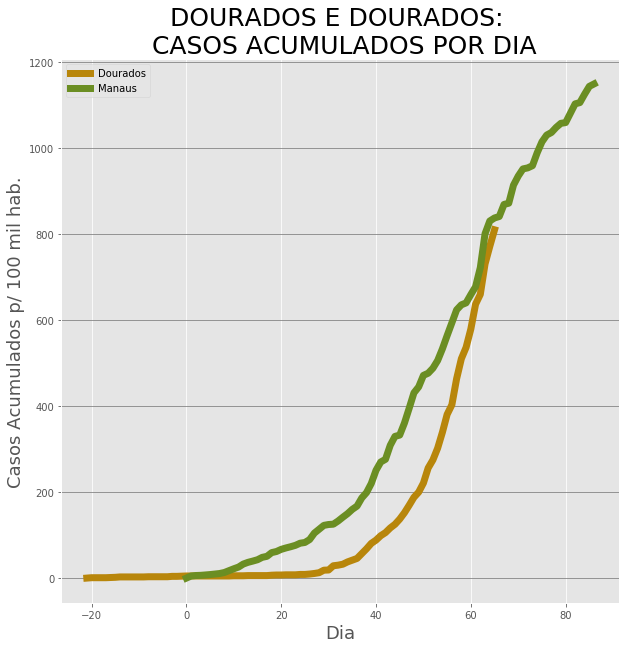

data início da reta ajustada 2020-05-25 00:00:00


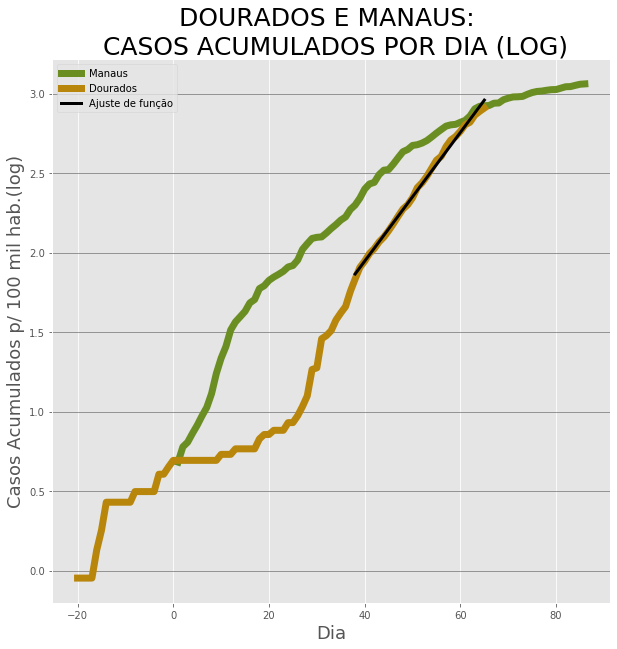


parâmetros da reta:  [0.04049871 0.32627887] 
 matriz de covariância:
 [[ 1.96855097e-07 -1.01380372e-05]
 [-1.01380372e-05  5.34953690e-04]]
10**0.04049870580655768 = 1.0977380190199408


In [210]:
comp_cidades(df_cidade1, df_cidade2)

In [173]:
df_est1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data               118 non-null    datetime64[ns]
 1   casosNovos         118 non-null    int64         
 2   obitosNovos        118 non-null    int64         
 3   casosAcumulado     118 non-null    int64         
 4   obitosAcumulado    118 non-null    int64         
 5   populacaoTCU2019   118 non-null    int32         
 6   CN_por_cemMil_Hab  118 non-null    float64       
 7   ON_por_cemMil_Hab  118 non-null    float64       
 8   CA_por_cemMil_Hab  118 non-null    float64       
 9   OA_por_cemMil_Hab  118 non-null    float64       
 10  dia_num            118 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(5)
memory usage: 9.8 KB


In [174]:
10**5

100000